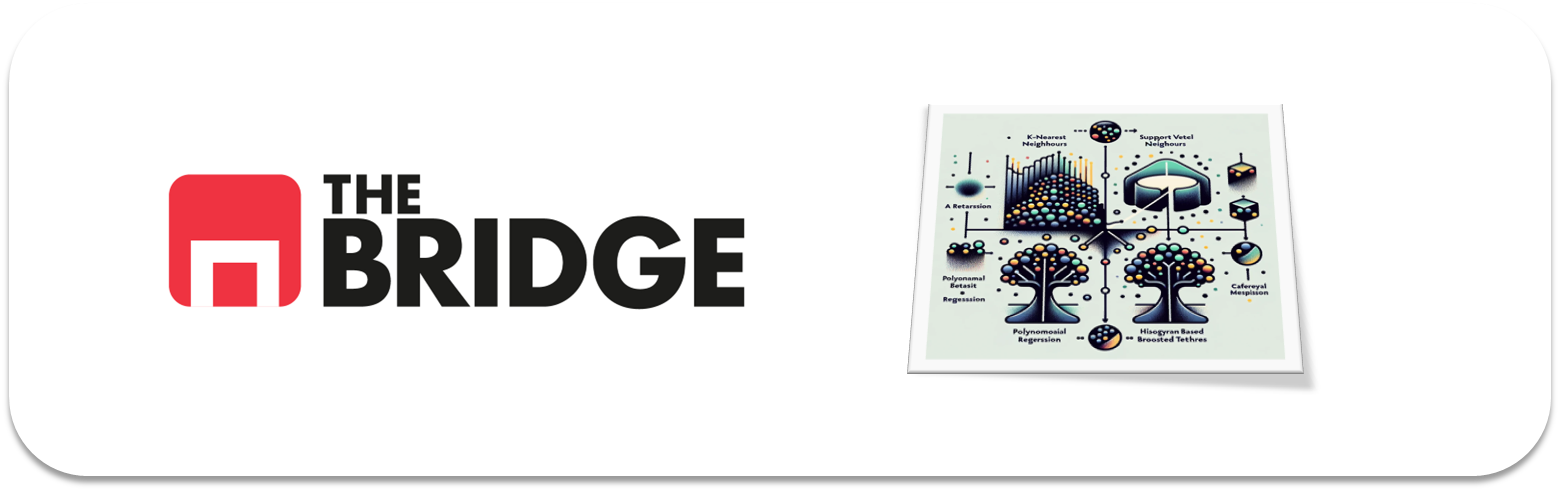

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor


In [2]:
def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """

    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()


### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

In [3]:
df = pd.read_csv("./data/wines_dataset.csv", sep = "|")

In [5]:
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.210,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.160,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.180,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.260,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.630,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red
5,5.7,0.265,0.28,6.90,0.036,46.0,150.0,0.99299,3.36,0.44,10.8,7,white
6,6.6,0.210,0.31,11.40,0.039,46.0,165.0,0.99795,3.41,0.44,9.8,7,white
7,6.7,0.310,0.30,2.10,0.038,18.0,130.0,0.99280,3.36,0.63,10.6,6,white
8,8.9,0.750,0.14,2.50,0.086,9.0,30.0,0.99824,3.34,0.64,10.5,5,red
9,7.5,0.420,0.20,1.40,0.060,15.0,168.0,0.99440,3.06,0.40,9.4,6,white


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [7]:
target_clf = "quality"
target_reg = "alcohol"

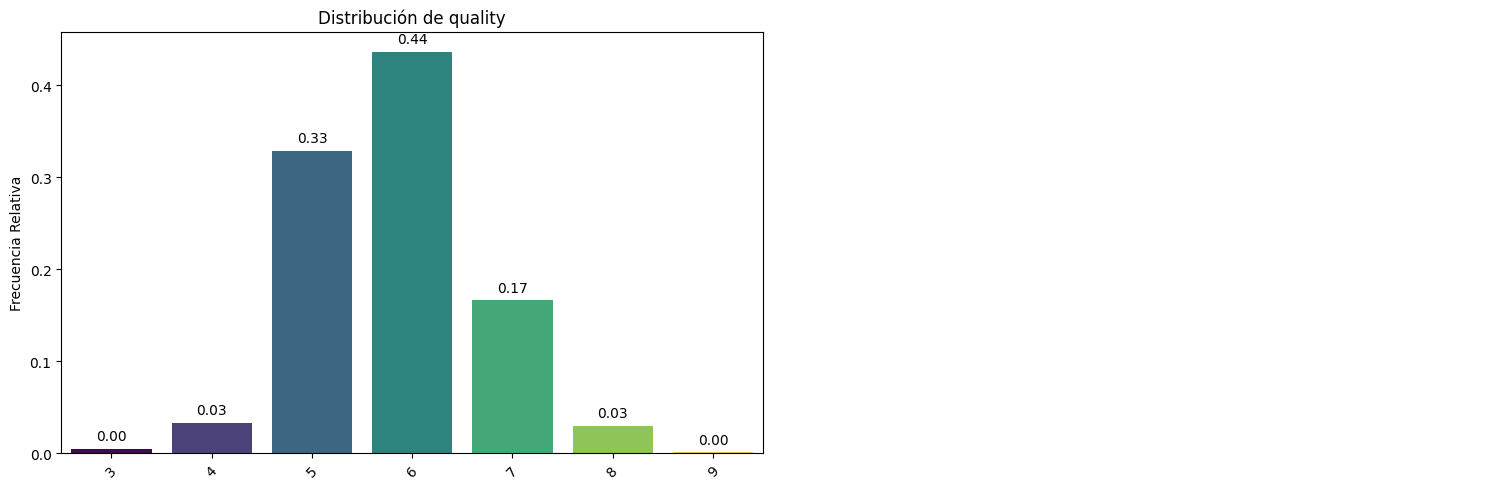

In [ ]:
# Para el caso del target de clasificacion: *

bt.pinta_distribucion_categoricas(df, [target_clf], mostrar_valores = True, relativa = True)

<Axes: xlabel='alcohol', ylabel='Count'>

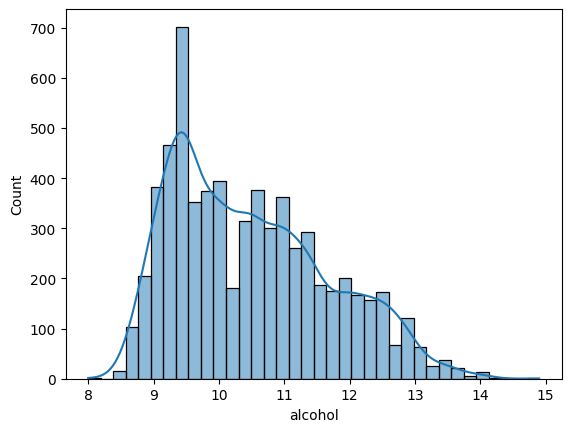

In [11]:
# Para el caso de target de regresion
sns.histplot(df[target_reg], kde = True)

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

Siguiendo el esquema:

1. Entendimiento del problema (selección de la métrica más adecuada)
2. Obtención de datos y primer contacto
3. Train y Test <- PARTIMOS DE AQUI
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)
5. Categoricas -> 0-1 -> MinMax (a,b), con a < b
6. Categoricas -> 0 a 10
7. Numéricas -> StandardScaler -> 2 juegos
8. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas
9. Selección e instanciación de modelos. Baseline
10. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)
11. TIEMPO es la clave -> 1) Tuneo/Ajusto los hiperparámetros; 2) Validación cruzada (set de validación)
12. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)
13. Hiperparámetro -> class_weight
14. Equilibrado del train set (Oversampling SMOTE, Undersampling….)
15. Evaluación contra test
16. Análisis de errores, posibles acciones futuras
17. EXTRA: Persistencia del modelo en disco

In [12]:
# Nos vale para los dos problemas: 
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

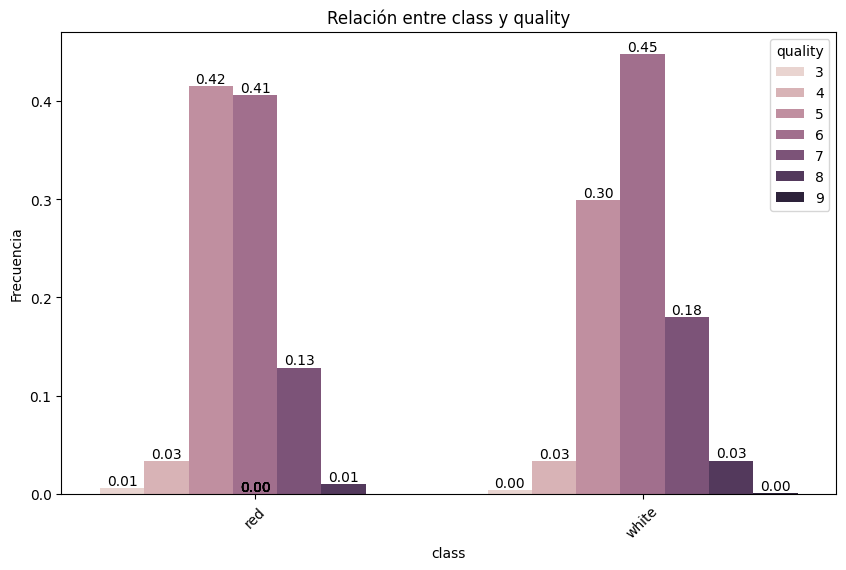

In [13]:
# Para el mini EDA vamos a hacer los dos uno detrás de otro y generaremos las listas de features si es necesario hay que quitar los targets correspondientes)

# Partimos de que son todas numericas excepto classs (y quality en el caso de regresión

#Clasificación Categóricas

bt.plot_categorical_relationship_fin(train_set, "class", target_clf, show_values= True, relative_freq=True)

In [14]:
features_cat_clf = ["class"]

In [15]:
# Analizamos las numéricas

features_num_clf = [col for col in train_set.columns if col != "class" and col != target_clf] # Me quedo con todas las que no son categoricas
print(len(features_num_clf)) # veo cuantas son para que utlizar si pairplot o las funciones de bt

11


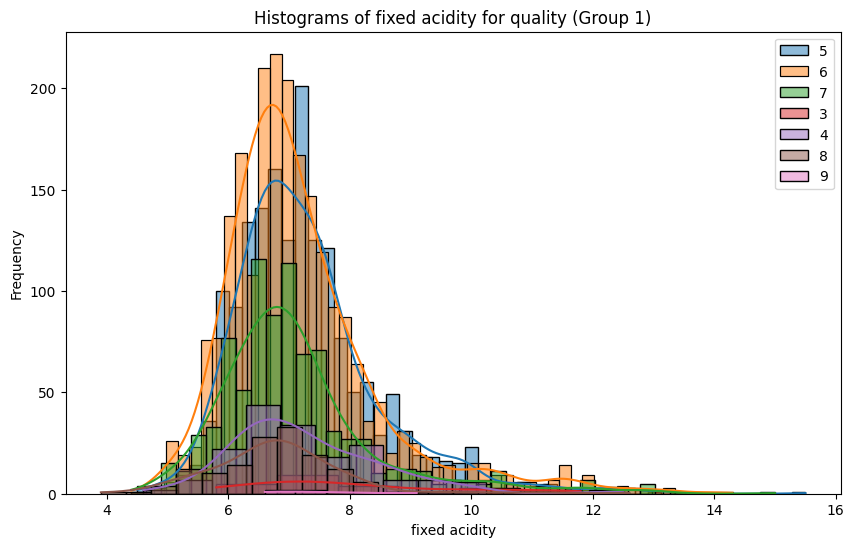

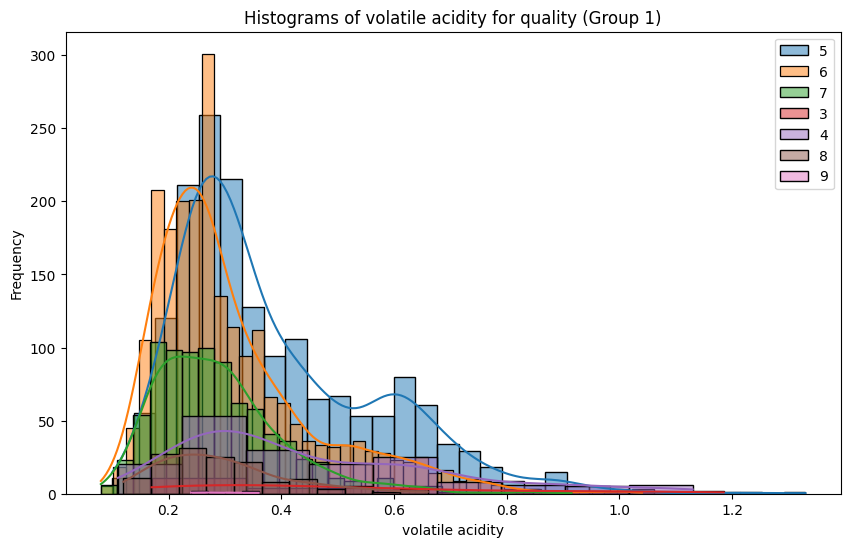

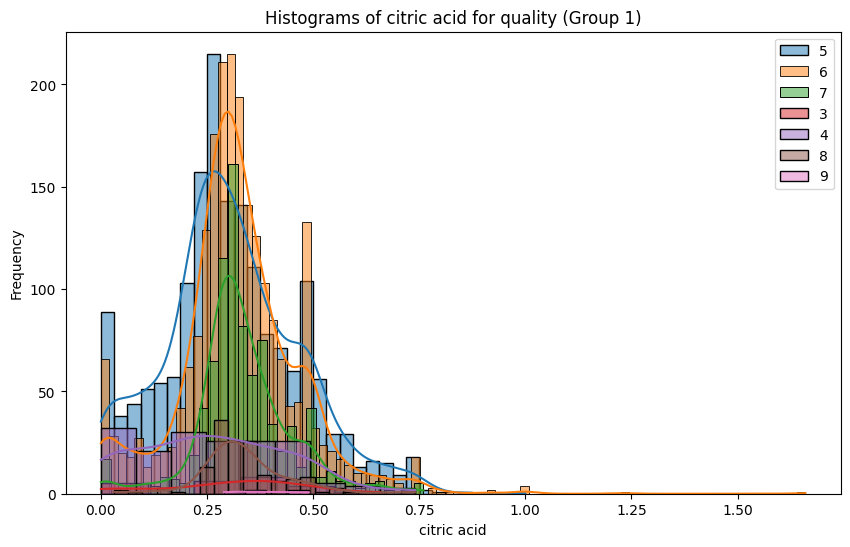

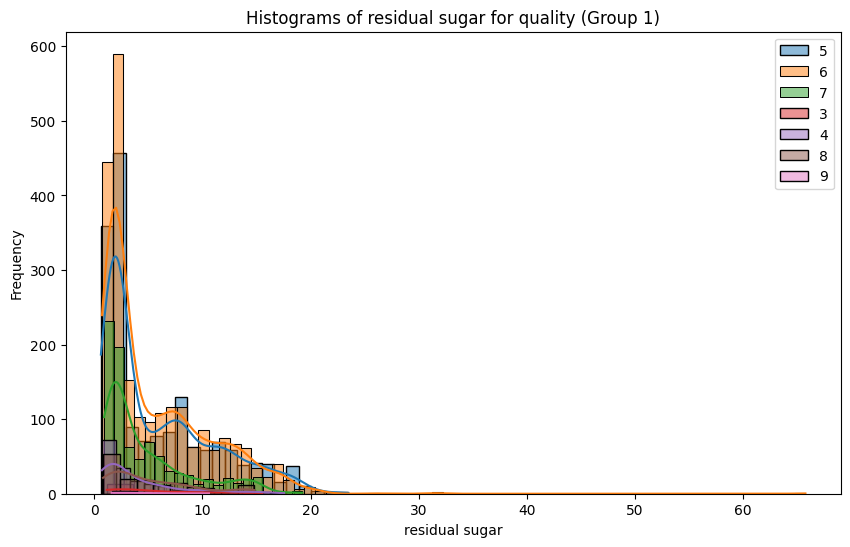

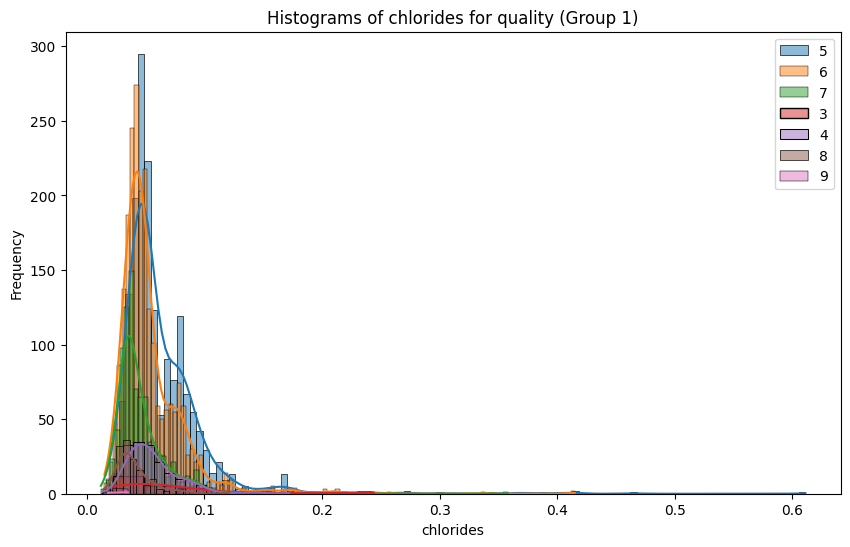

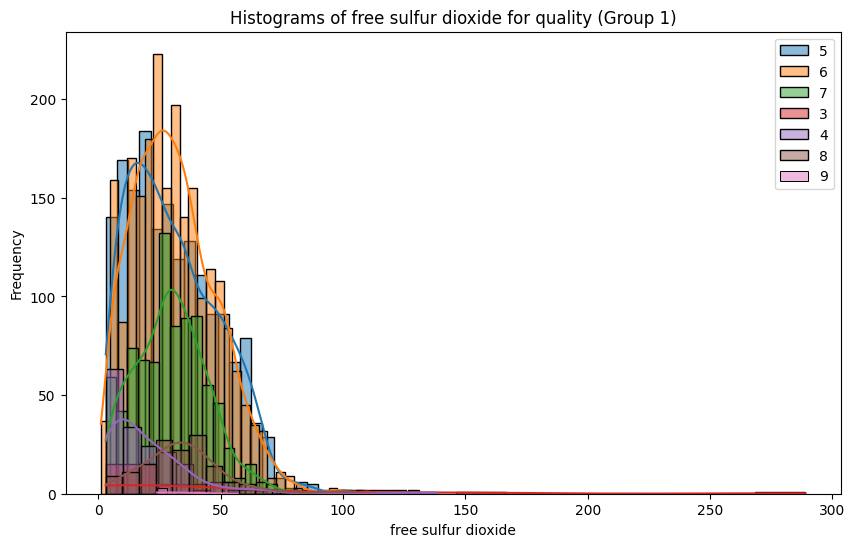

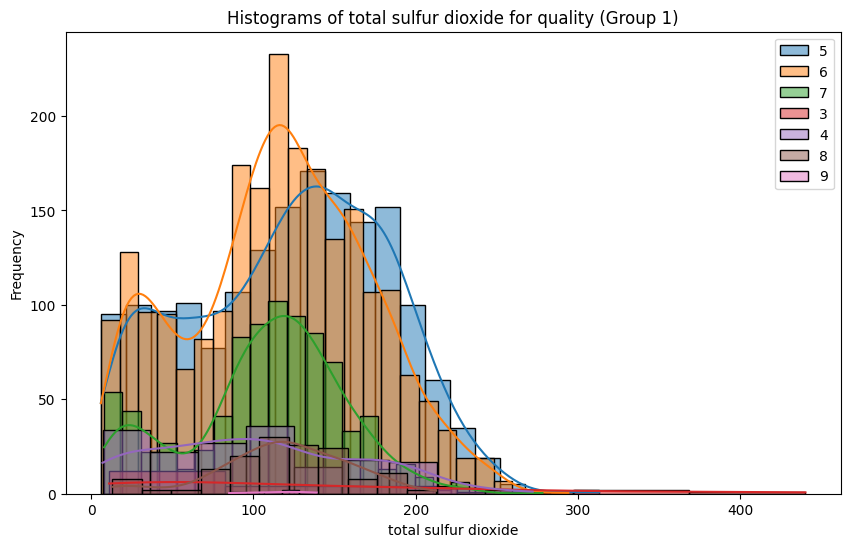

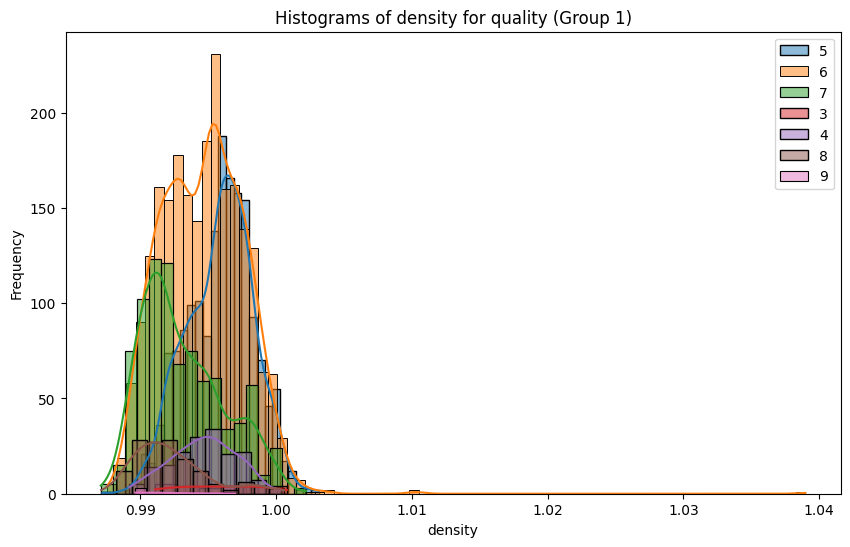

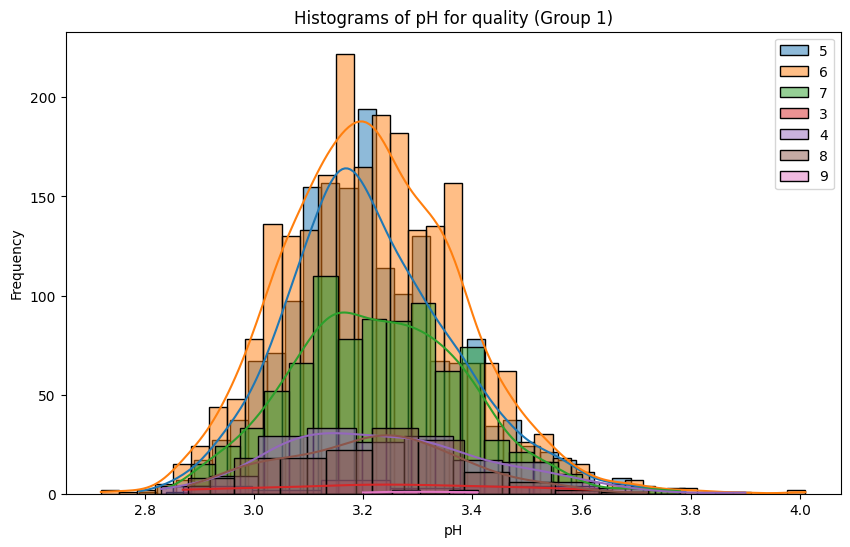

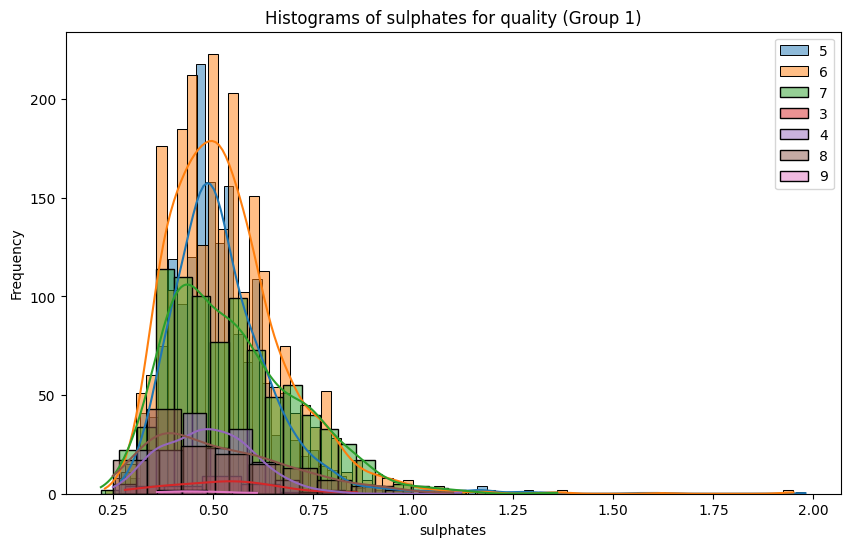

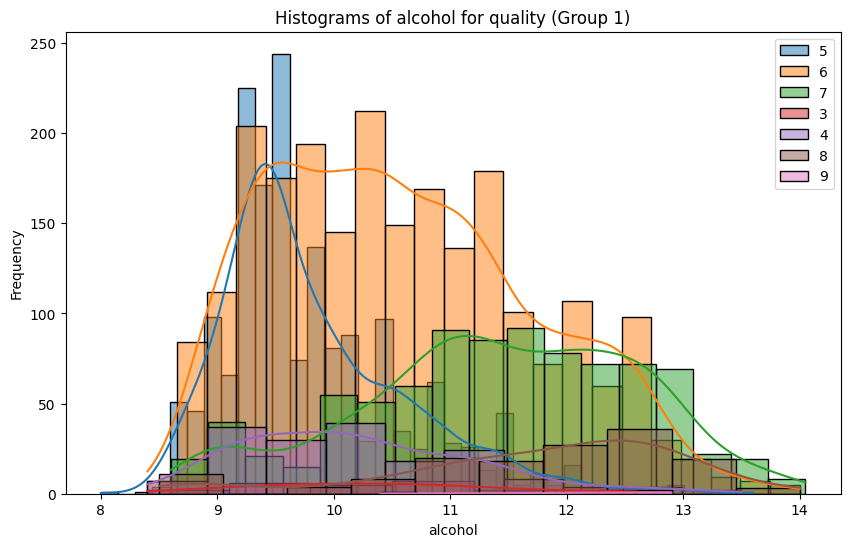

In [16]:
# Utilizando bootviztools
for col in features_num_clf:
    bt.plot_grouped_histograms(train_set, cat_col= target_clf, num_col=col, group_size=train_set[target_clf].nunique())

In [18]:
valores_target = train_set[target_clf].unique().tolist()

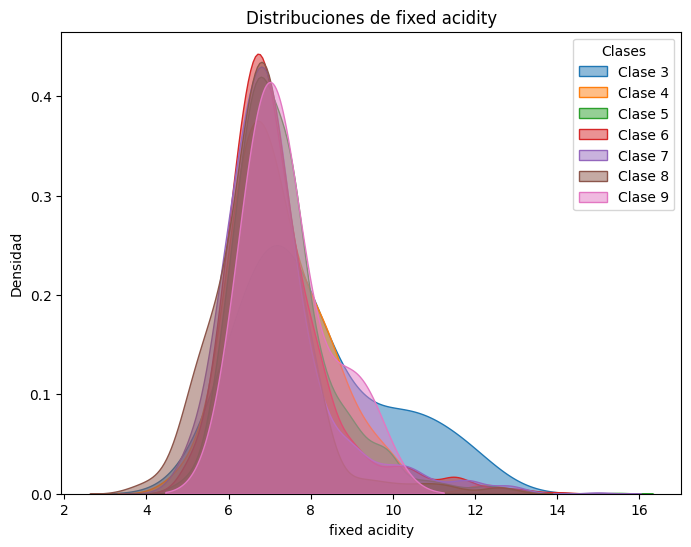

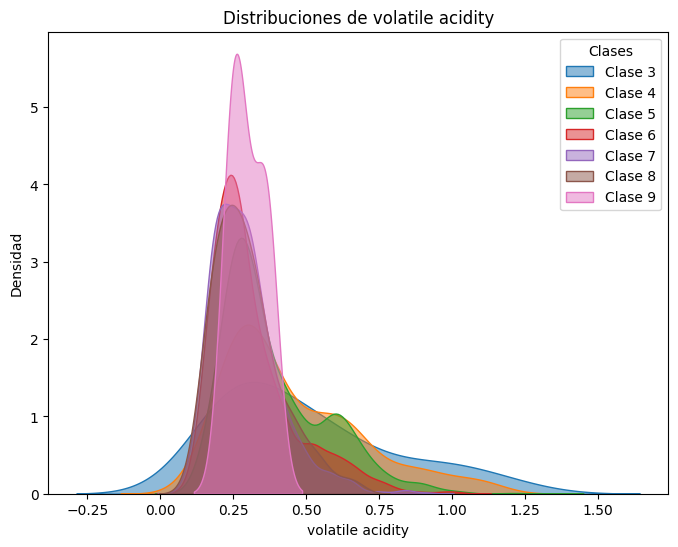

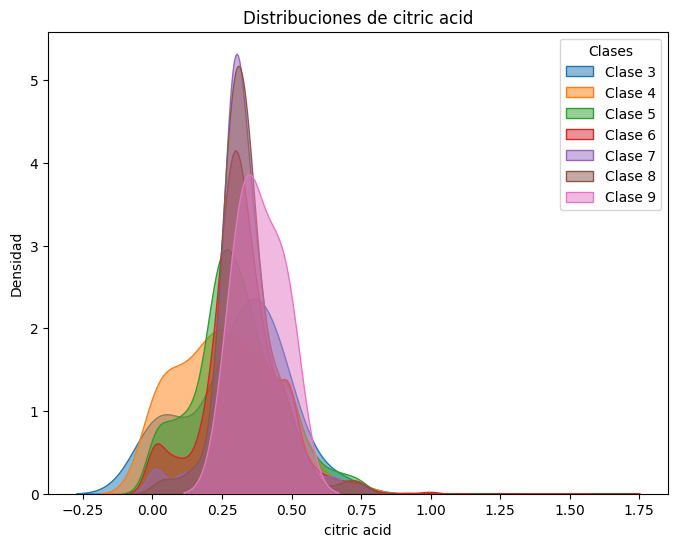

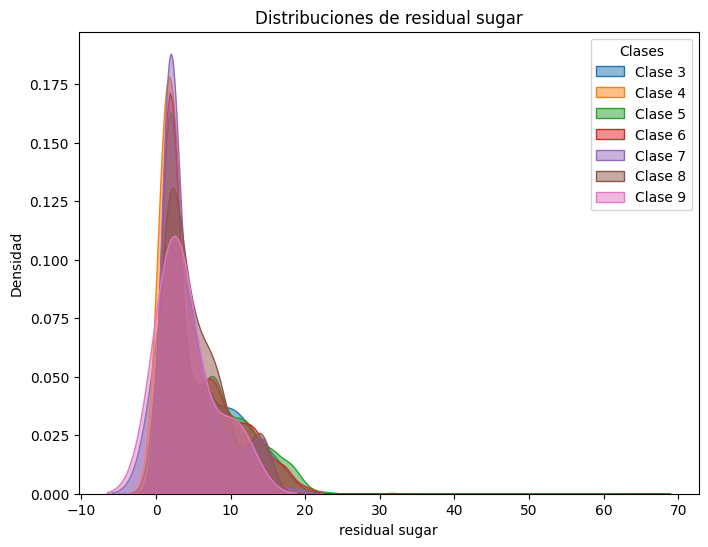

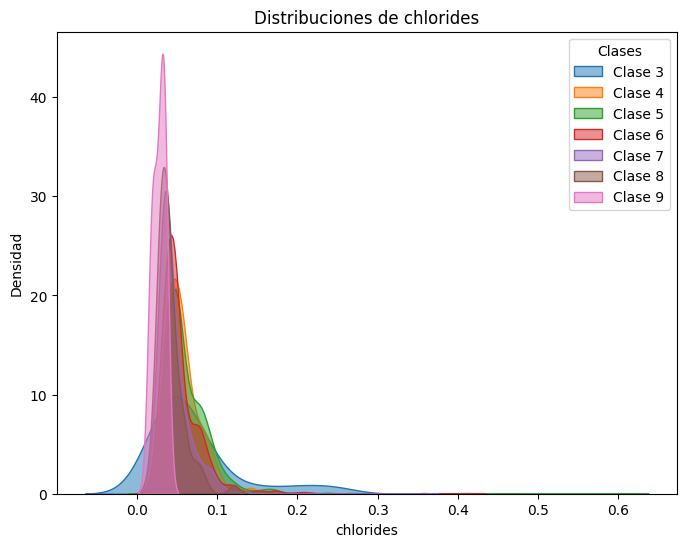

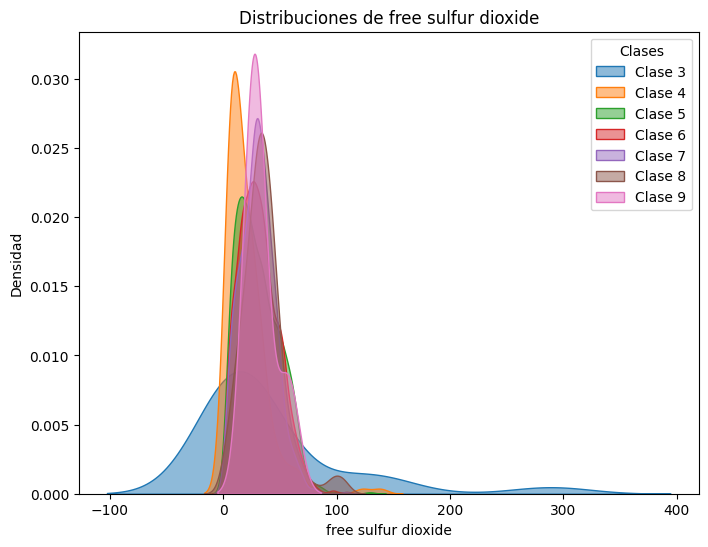

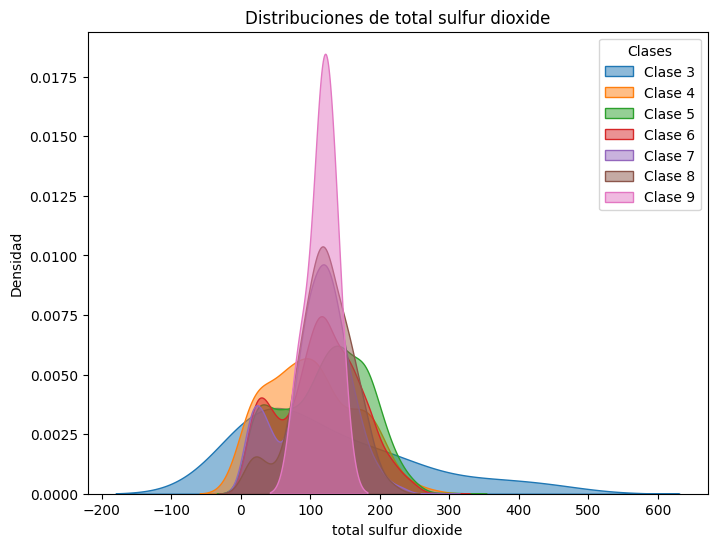

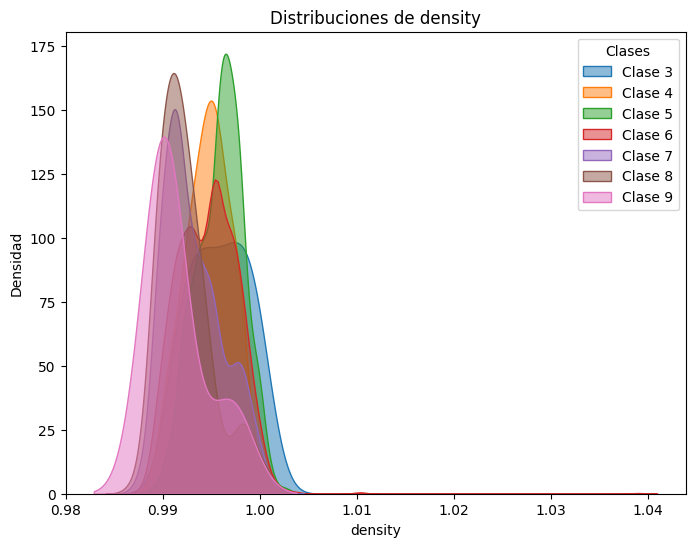

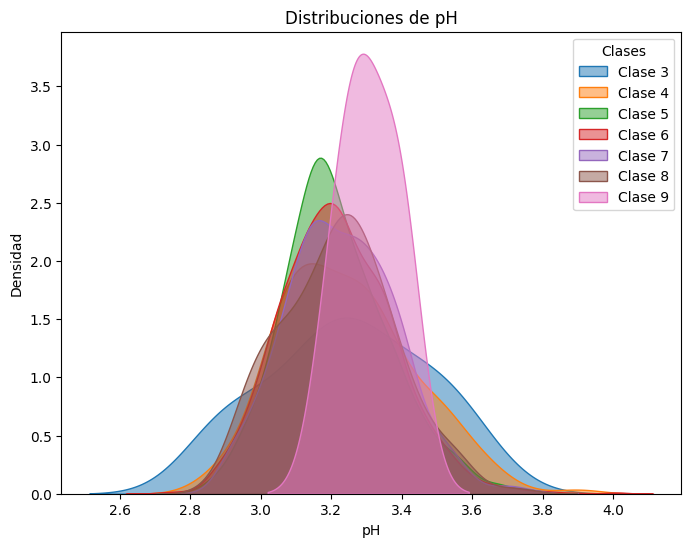

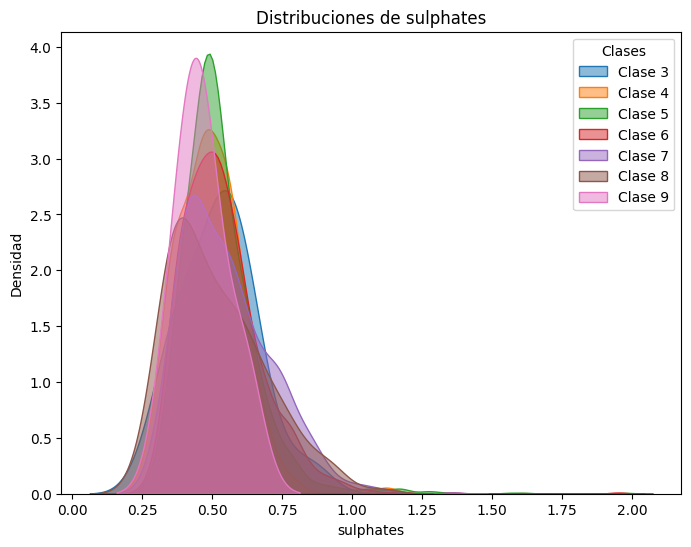

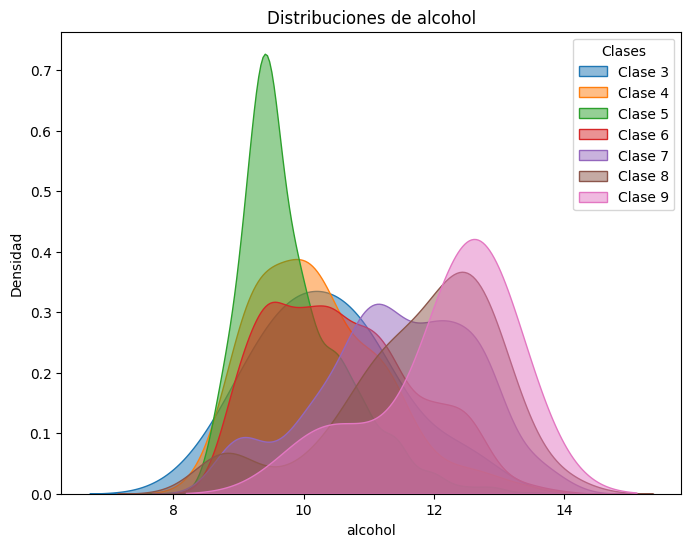

In [20]:
for col in features_num_clf:
    plt.figure(figsize=(8,6))
    for i in sorted(valores_target):
        sns.kdeplot(
            train_set[train_set[target_clf] == i][col],
            fill=True,
            alpha=0.5,
            label=f"Clase {i}"
        )
    plt.title(f"Distribuciones de {col}")
    plt.xlabel(col)
    plt.ylabel("Densidad")
    plt.legend(title="Clases")
    plt.show()

In [21]:
features_cat_reg = ["class","quality"]

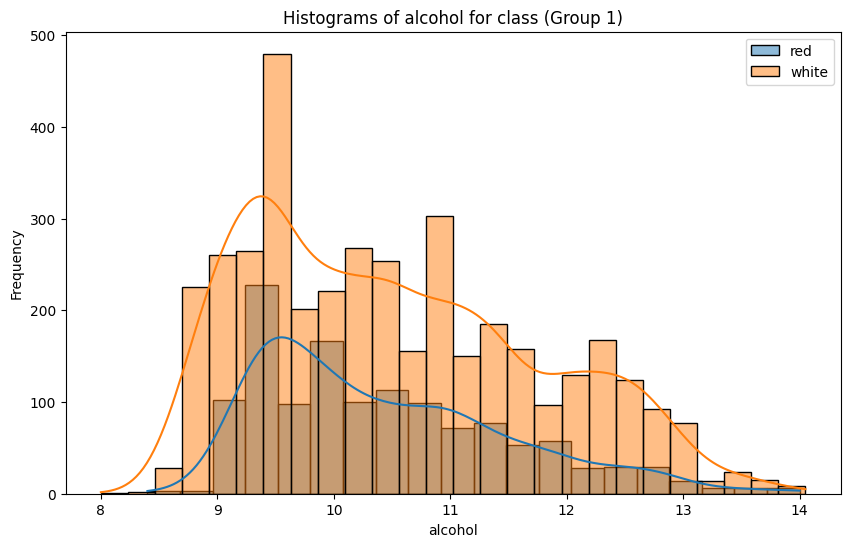

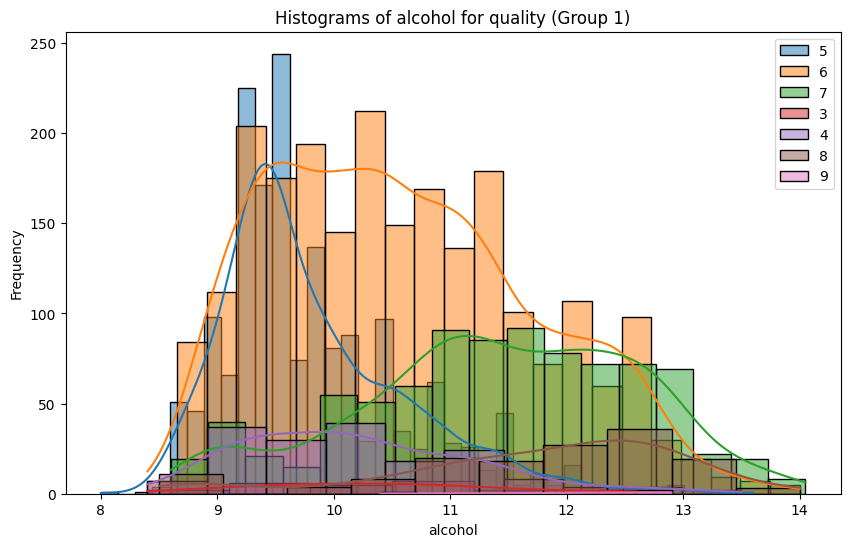

In [22]:
# Mini EDA Regresión 
#Categóricas: class y quality
#Quality y alcohol ya la hemos visto ante al estudiar el bivariante del problema de clasificación: es la ultima gráfica y si hay relación

for col in features_cat_reg:
    bt.plot_grouped_histograms(train_set, cat_col=col, num_col=target_reg, group_size=train_set[col].nunique())

In [23]:
# Estudiamos ahora las correlacions y el mapa de correlaciones

corr = train_set.corr(numeric_only="True")
np.abs(corr[target_reg]).sort_values(ascending = False)

alcohol                 1.000000
density                 0.682345
quality                 0.450403
residual sugar          0.357459
total sulfur dioxide    0.272970
chlorides               0.260508
free sulfur dioxide     0.188460
pH                      0.116497
fixed acidity           0.091964
volatile acidity        0.036041
citric acid             0.005690
sulphates               0.000412
Name: alcohol, dtype: float64

In [24]:
r_min = 0.10
features_num_reg_1 = corr[target_reg][(np.abs(corr[target_reg]) > r_min)].index.to_list()
features_num_reg_1.remove("quality")
features_num_reg_1.remove(target_reg)
features_num_reg_2 = [col for col in train_set.columns if col not in features_num_reg_1 and col != target_reg
                      and col not in features_cat_reg]

In [25]:
features_num_reg_1

['residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH']

<Axes: >

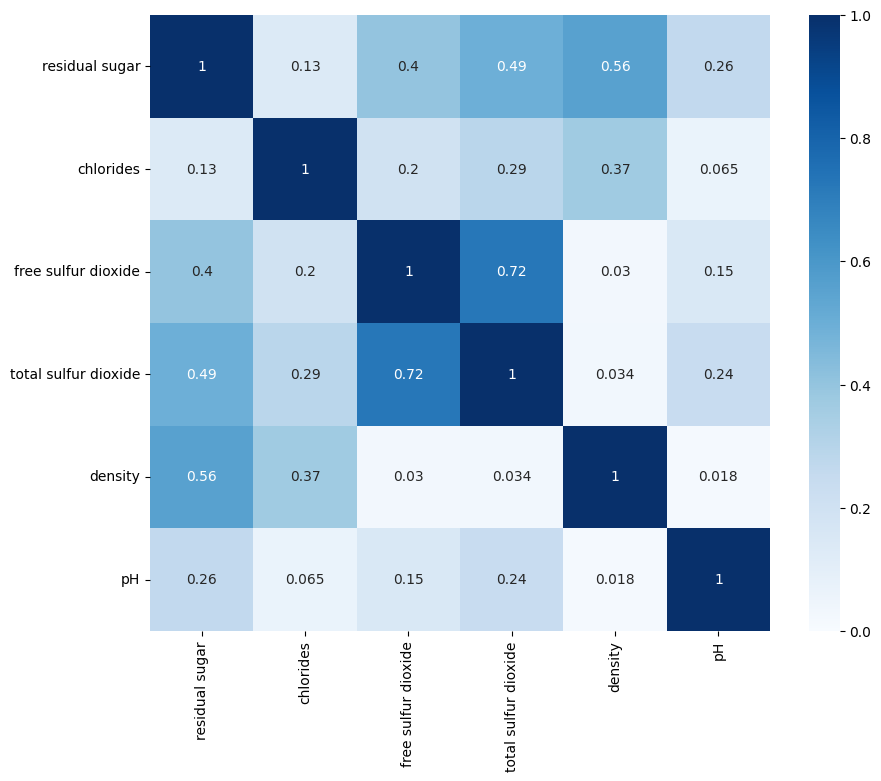

In [27]:
plt.figure(figsize=(10,8))
sns.heatmap(np.abs(train_set[features_num_reg_1].corr(numeric_only="True")), annot=True, cmap= "Blues",vmin= 0,vmax= 1)

In [28]:
features_num_reg_1.remove("free sulfur dioxide") # Es la que menos correla con alcohol.
features_num_reg_2.append("free sulfur dioxide")

In [29]:
# Tratamos ahora las features (necesitamos escalar porque vamos a emplear un KNN y además tenemos que convertir las categóricas)

train_set["class"] = (train_set["class"] == "white").astype(int) # white -> clase 1, red -> clase 0
test_set["class"] = (test_set["class"] == "white").astype(int) # white -> clase 1, red -> clase 0

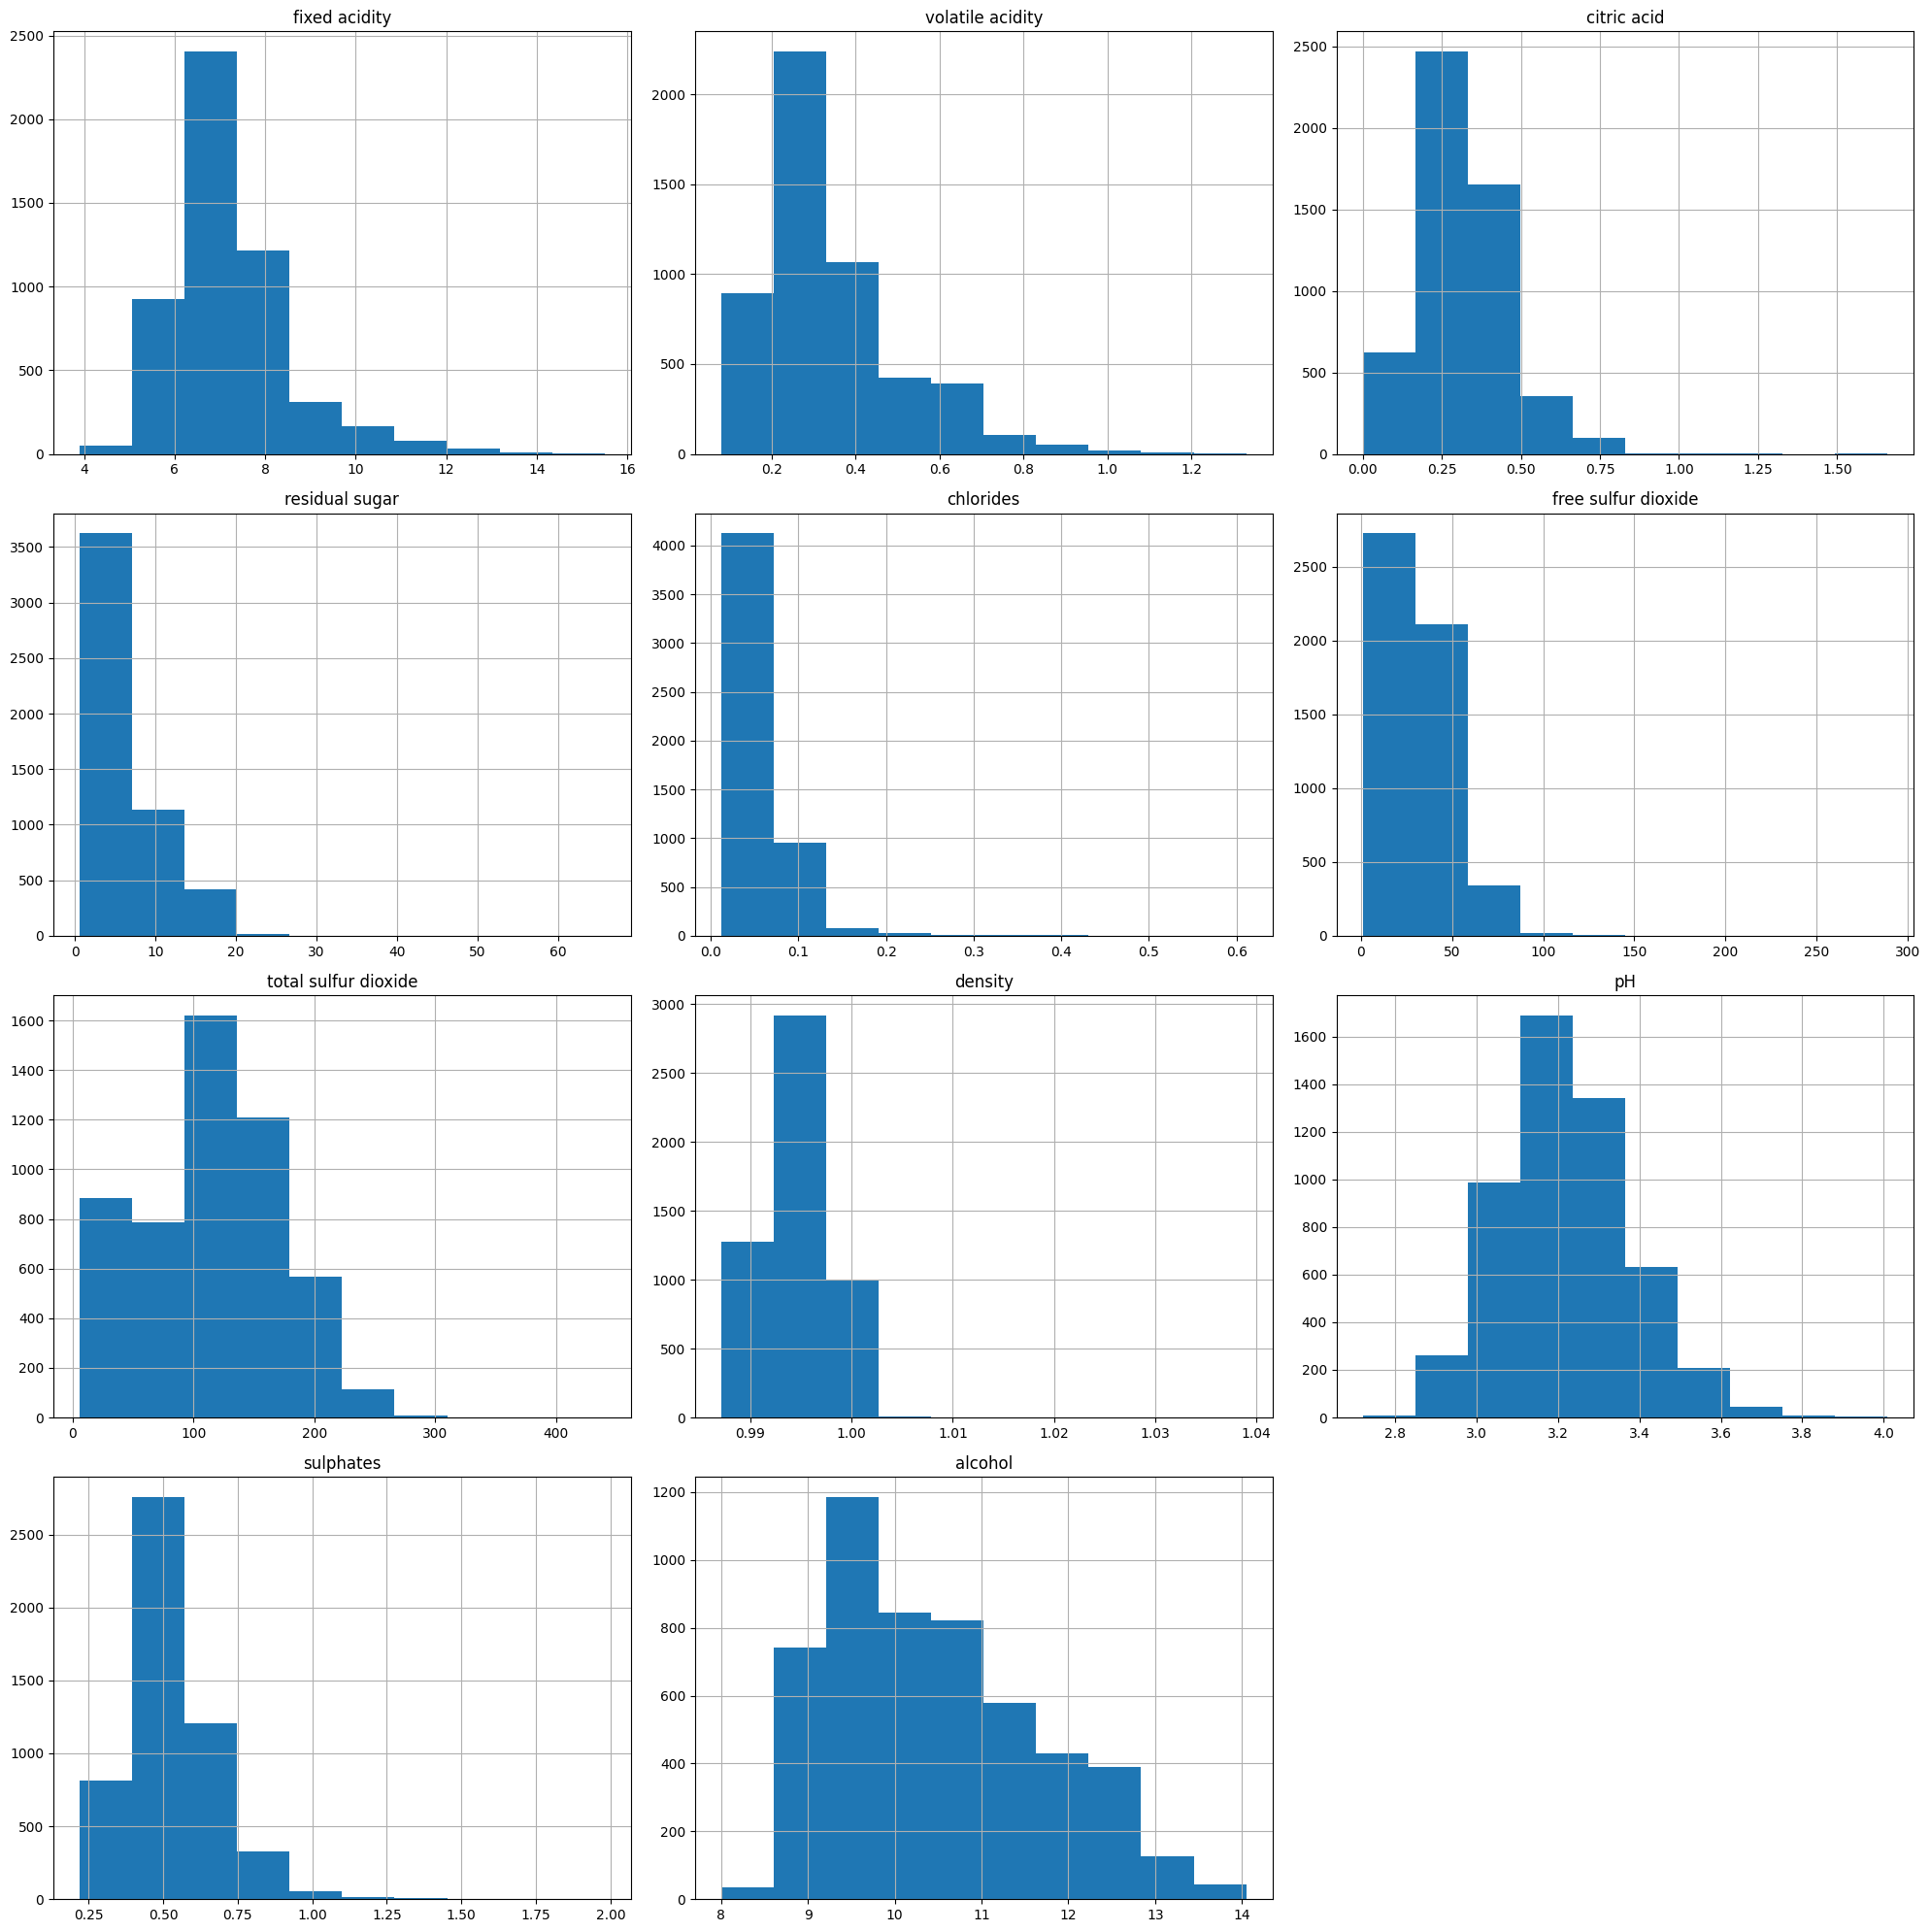

In [30]:
# Dejamos "quality" y "alcohol" para el final porque son los dos targets, tendremos que procesar en una sí y en otra no

train_set[features_num_clf].hist(figsize = (20,20))
plt.tight_layout()

In [31]:
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

In [32]:
features_to_transform = [
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide"
]

In [ ]:
for col in features_to_transform:
    desplaza = 0
    
    if train_set_scaled[col].min() <= 0:
        desplaza = int(abs(train_set_scaled[col].min())) + 1
    train_set_scaled[col] = np.log(train_set_scaled[col] + desplaza)
    test_set_scaled[col] = np.log(test_set_scaled[col] + desplaza)

In [34]:
features_num_clf

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

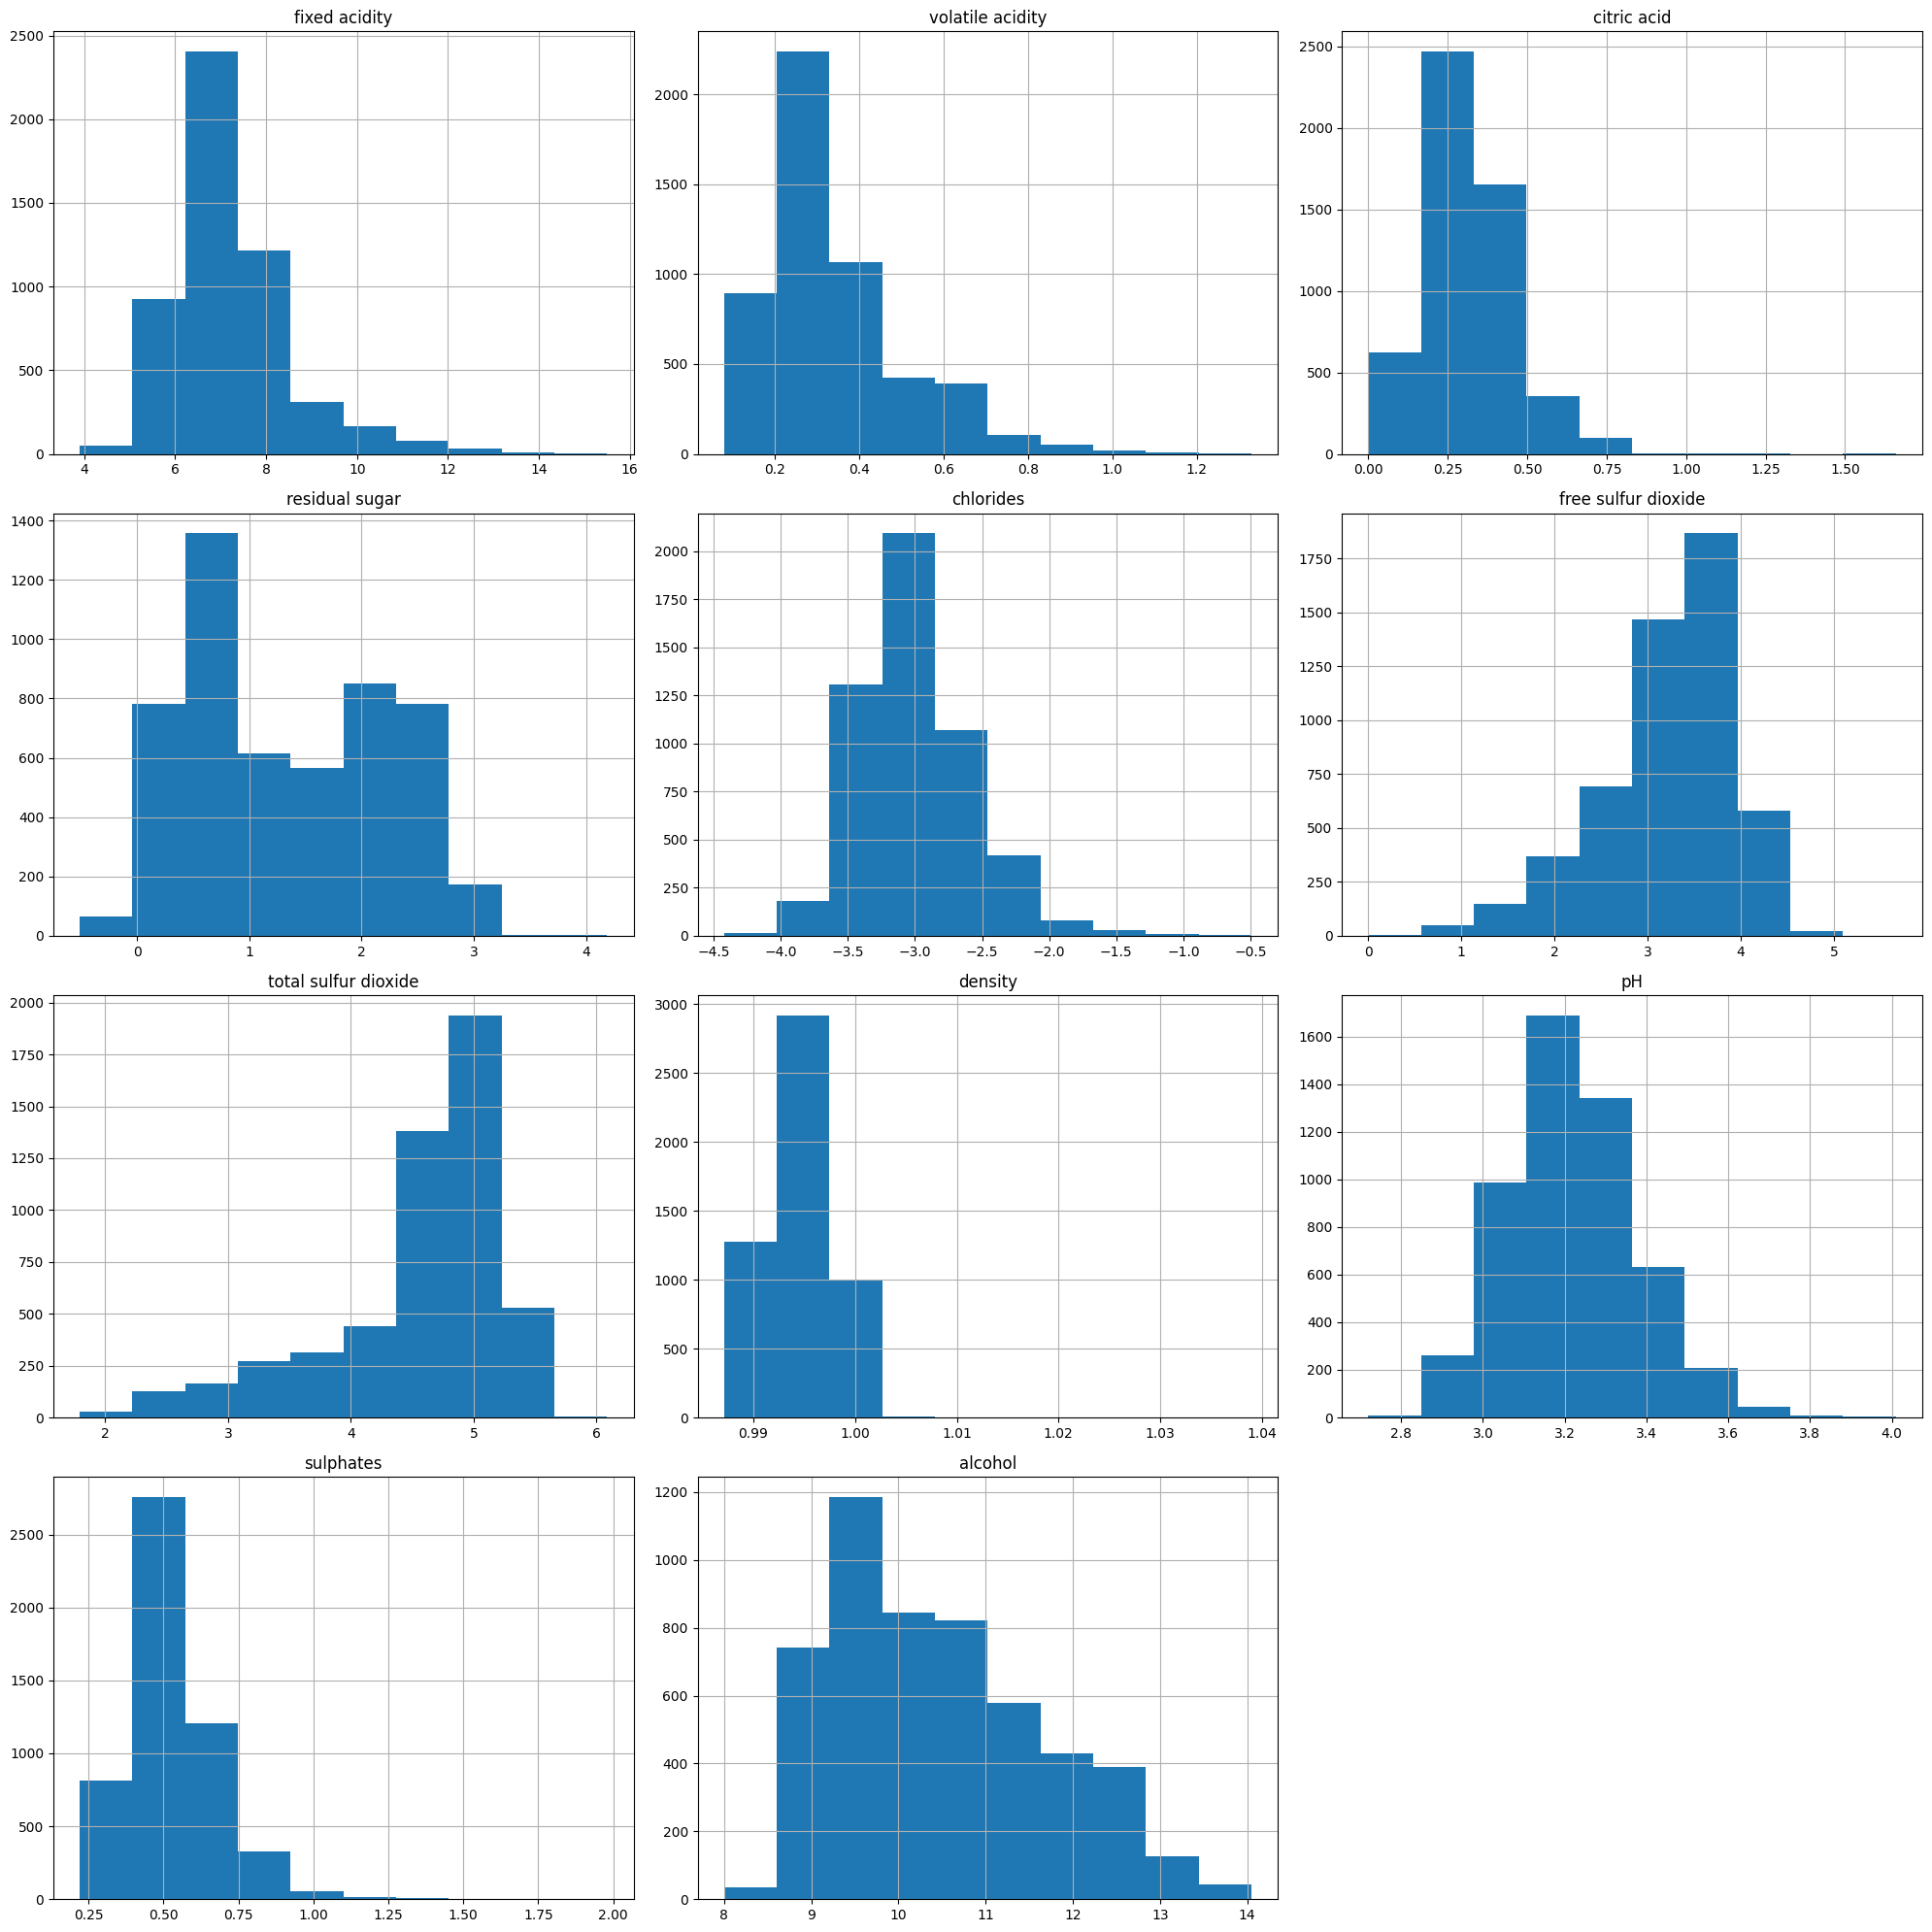

In [36]:
train_set_scaled[features_num_clf].hist(figsize = (20,20))
plt.tight_layout()
plt.show()

In [37]:
# En features_num_clf están todas las numéricas, así que me ahorra tener que tratarlas por separado,
# luego sí que las seleccionaremos por separado. Pero ya separando para regresión y para clasificación.

scaler = StandardScaler()
features_num_reg = features_num_clf.copy()
features_num_reg.remove("alcohol")
train_set_scaled[features_num_reg] = scaler.fit_transform(train_set_scaled[features_num_reg])
test_set_scaled[features_num_reg] = scaler.transform(test_set_scaled[features_num_reg])

In [38]:
train_set_scaled[features_num_reg].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
count,5.197000e+03,5.197000e+03,5.197000e+03,5.197000e+03,5.197000e+03,5.197000e+03,5.197000e+03,5.197000e+03,5.197000e+03,5.197000e+03
mean,1.093774e-16,-2.816467e-16,-9.297076e-17,2.734434e-18,5.714968e-16,-1.709021e-16,1.668005e-16,5.706764e-14,2.365286e-16,1.955120e-16
std,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00,1.000096e+00
min,-2.560983e+00,-1.593077e+00,-2.187140e+00,-2.130418e+00,-3.375535e+00,-4.578518e+00,-3.851433e+00,-2.524538e+00,-3.119464e+00,-2.103135e+00
25%,-6.287648e-01,-6.723928e-01,-4.743893e-01,-8.590345e-01,-6.595501e-01,-5.432713e-01,-3.193079e-01,-7.815705e-01,-6.821081e-01,-6.833920e-01
50%,-1.650324e-01,-3.041192e-01,-6.332925e-02,-2.678746e-01,-1.587052e-01,2.174037e-01,2.927357e-01,6.169387e-02,-5.714499e-02,-1.425376e-01
75%,3.759889e-01,3.710490e-01,5.532609e-01,8.815795e-01,6.052801e-01,7.105928e-01,6.811085e-01,7.588809e-01,6.303145e-01,4.659237e-01
max,6.404511e+00,6.079289e+00,9.185522e+00,3.305764e+00,5.884922e+00,3.491975e+00,2.123631e+00,1.469598e+01,4.942560e+00,9.795662e+00


In [39]:
# Separamos:

train_set_scaled_clf = train_set_scaled.copy()
test_set_scaled_clf = test_set_scaled.copy()

train_set_scaled_clf["alcohol"] = scaler.fit_transform(train_set_scaled_clf[["alcohol"]])
test_set_scaled_clf["alcohol"] = scaler.transform(test_set_scaled_clf[["alcohol"]])


In [44]:
# Creamos X,y variados

y_train_clf = train_set[target_clf]
y_test_clf = test_set[target_clf]
y_train_reg = train_set[target_reg]
y_test_reg = test_set[target_reg]

X_train_clf_dict = {}
X_test_clf_dict = {}

X_train_reg_dict = {}
X_test_reg_dict = {}

# Juegos X_train clasificación
features_set_name = ["todas"]
features_set = [features_cat_clf + features_num_clf]

for set_name, feature_list in zip(features_set_name, features_set):
    print(feature_list)
    X_train_clf_dict[set_name] = train_set_scaled_clf[feature_list]
    X_test_clf_dict[set_name] = test_set_scaled_clf[feature_list]

# Juegos X_train regresión
features_set_name = ["cat+num_1", "todas"]
features_set = [features_cat_reg + features_num_reg_1, features_cat_reg + features_num_reg_2]

for set_name, feature_list in zip(features_set_name, features_set):
    print(feature_list)
    X_train_reg_dict[set_name] = train_set_scaled[feature_list]
    X_test_reg_dict[set_name] = test_set_scaled[feature_list]



['class', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
['class', 'quality', 'residual sugar', 'chlorides', 'total sulfur dioxide', 'density', 'pH']
['class', 'quality', 'fixed acidity', 'volatile acidity', 'citric acid', 'sulphates', 'free sulfur dioxide']


In [45]:
# Ya lo que queda de sección nos centramos en clasificación

# Instanciamos modelos
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_ten_clf = KNeighborsClassifier(n_neighbors=10)
lr_clf = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(max_depth=10, random_state=42)
lgb_clf = LGBMClassifier(max_depth=10, random_state=42, verbose=-100)

modelos_clf = {
    "KNN_5": knn_clf,
    "KNN_10": knn_ten_clf,
    "Regresion Logistica": lr_clf,
    "Random Forest": rf_clf,
    "LightGBM": lgb_clf
}


In [46]:
for feature_set, X_train in X_train_clf_dict.items():
    print(f"Para el set {feature_set}:")
    for tipo, modelo in modelos_clf.items():
        print(f"{tipo}: ", end=" ")
        print(np.mean(cross_val_score(modelo, X_train, y_train_clf, cv=5, scoring="accuracy")))
    print("********")

Para el set todas:
KNN_5:  0.5406963056193086
KNN_10:  0.5453120604131191
Regresion Logistica:  0.5433875027763382
Random Forest:  0.6203575923595173
LightGBM:  0.6405648922780779
********


In [47]:
# Los valores son realmente flojos, pero es debido al fuerte desequilibrio que hay entre clases,
# deberíamos hacer un equilibrado, pero que en nuestro caso se va a centrar por tiempo disponible
# en usar el parámetro class_weights y el más o menos equivalente de weights en KNN

# Instanciamos modelos
knn_clf = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn_ten_clf = KNeighborsClassifier(n_neighbors=10, weights="distance")
lr_clf = LogisticRegression(max_iter=1000, class_weight="balanced")
rf_clf = RandomForestClassifier(max_depth=10, random_state=42, class_weight="balanced")
lgb_clf = LGBMClassifier(max_depth=10, random_state=42, verbose=-100, class_weight="balanced")

modelos_clf = {
    "KNN_5": knn_clf,
    "KNN_10": knn_ten_clf,
    "Regresion Logistica": lr_clf,
    "Random Forest": rf_clf,
    "LightGBM": lgb_clf
}


In [48]:
for feature_set, X_train in X_train_clf_dict.items():
    print(f"Para el set {feature_set}:")
    for tipo, modelo in modelos_clf.items():
        print(f"{tipo}: ", end=" ")
        print(np.mean(cross_val_score(modelo, X_train, y_train_clf, cv=5, scoring="accuracy")))
    print("********")

Para el set todas:
KNN_5:  0.6276693566298956
KNN_10:  0.6480648922780781
Regresion Logistica:  0.34443214629451396
Random Forest:  0.571678574072703
LightGBM:  0.6259372917746354
********


In [50]:
# Todos los modelos han mejorado, e incluso podríamos quedarnos con la regresión logística, pero
# vamos a hacerlo con LightGBM que parece más consistente en todas las pruebas y también
# permite a título ilustrativo más juego en el aspecto de hiperparámetros.

param_grid = {
    "n_estimators": [100, 200, 1000],
    "max_depth": [1, 5, 10, 20],
    "learning_rate": [0.1, 0.3, 0.6, 1, 0.01],
    "class_weight": ["balanced", None]
}

lgb_grid = GridSearchCV(lgb_clf,
                        param_grid=param_grid,
                        cv=5,
                        scoring="balanced_accuracy")

lgb_grid.fit(X_train_clf_dict["todas"], y_train_clf)

GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced', max_depth=10,
                                      random_state=42, verbose=-100),
             param_grid={'class_weight': ['balanced', None],
                         'learning_rate': [0.1, 0.3, 0.6, 1, 0.01],
                         'max_depth': [1, 5, 10, 20],
                         'n_estimators': [100, 200, 1000]},
             scoring='balanced_accuracy')

In [51]:
print(lgb_grid.best_params_)
print(lgb_grid.best_score_)

{'class_weight': 'balanced', 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 200}
0.37134629750829734


In [52]:
print(lgb_grid.get_params())

{'cv': 5, 'error_score': nan, 'estimator__boosting_type': 'gbdt', 'estimator__class_weight': 'balanced', 'estimator__colsample_bytree': 1.0, 'estimator__importance_type': 'split', 'estimator__learning_rate': 0.1, 'estimator__max_depth': 10, 'estimator__min_child_samples': 20, 'estimator__min_child_weight': 0.001, 'estimator__min_split_gain': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__num_leaves': 31, 'estimator__objective': None, 'estimator__random_state': 42, 'estimator__reg_alpha': 0.0, 'estimator__reg_lambda': 0.0, 'estimator__subsample': 1.0, 'estimator__subsample_for_bin': 200000, 'estimator__subsample_freq': 0, 'estimator__verbose': -100, 'estimator': LGBMClassifier(class_weight='balanced', max_depth=10, random_state=42,
               verbose=-100), 'n_jobs': None, 'param_grid': {'n_estimators': [100, 200, 1000], 'max_depth': [1, 5, 10, 20], 'learning_rate': [0.1, 0.3, 0.6, 1, 0.01], 'class_weight': ['balanced', None]}, 'pre_dispatch': '2*n_jobs'

In [53]:
#Evaluamos contra test y veamos la matriz de confusion para entender los erroes

y_pred = lgb_grid.best_estimator_.predict(X_test_clf_dict["todas"])
print(classification_report(y_test_clf, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.16      0.37      0.23        43
           5       0.62      0.62      0.62       432
           6       0.64      0.39      0.48       562
           7       0.40      0.65      0.50       210
           8       0.34      0.64      0.45        47
           9       0.00      0.00      0.00         0

    accuracy                           0.51      1300
   macro avg       0.31      0.38      0.32      1300
weighted avg       0.57      0.51      0.52      1300



c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

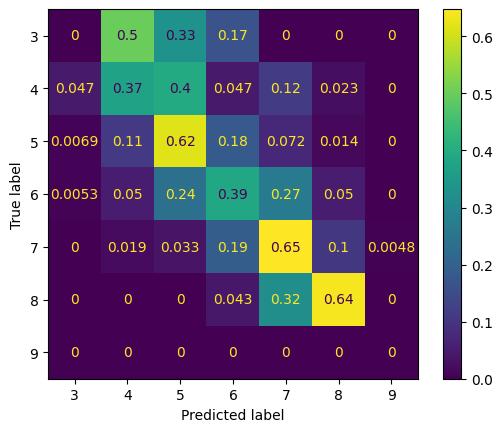

In [54]:
ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred, normalize = "true")

### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisicoquímicas, su clase y la puntuación de calidad que le ha sido otorgada.  

Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar, realiza un pequeño análisis de errores.  

_Todo el trabajo está hecho para centrarnos en los modelos y eso vamos a ver empleando además el MAPE como comparativa (porque ninguno tiene 0 como grado alcohólico)._

In [55]:
rf_reg = RandomForestRegressor(max_depth=10, random_state=42)
lgb_reg = LGBMRegressor(max_depth=10, random_state=42, verbose=-100)
xgb_reg = XGBRegressor(max_depth=10, random_state=42)

modelos_reg = {
    "Random Forest": rf_reg,
    "LightGBM": lgb_reg,
    "XGBoost Regressor": xgb_reg
}

In [56]:
for feature_set, X_train in X_train_reg_dict.items():
    print(f"Para el set {feature_set}:")
    for tipo, modelo in modelos_reg.items():
        print(f"{tipo}: ", end=" ")
        print(-np.mean(cross_val_score(modelo, X_train, y_train_reg, cv=5, scoring="neg_mean_absolute_percentage_error")))
    print("********")

Para el set cat+num_1:
Random Forest:  0.03615878791282648
LightGBM:  0.035972036701112875
XGBoost Regressor:  0.03139003158106459
********
Para el set todas:
Random Forest:  0.06254239621927513
LightGBM:  0.06264522529765973
XGBoost Regressor:  0.05298598194768991
********


En este caso es más interesante usar menos features y nos quedaríamos con el Random Forest por simplicidad frente XGBoost y métricas similares (los errores son practicamente nulos, lo clava frente al otro problema)

In [57]:
param_grid = {
    "n_estimators": [100, 200, 1000],
    "max_depth": [1, 5, 10, 20],
    "max_features": ["log2", "sqrt", None]
}

rf_grid = GridSearchCV(rf_reg,
                       param_grid=param_grid,
                       cv=5,
                       scoring="neg_mean_absolute_percentage_error")

rf_grid.fit(X_train_reg_dict["todas"], y_train_reg)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=10, random_state=42),
             param_grid={'max_depth': [1, 5, 10, 20],
                         'max_features': ['log2', 'sqrt', None],
                         'n_estimators': [100, 200, 1000]},
             scoring='neg_mean_absolute_percentage_error')

In [58]:
print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'max_depth': 20, 'max_features': 'log2', 'n_estimators': 1000}
-0.05487178824173966


In [59]:
y_pred = rf_grid.best_estimator_.predict(X_test_reg_dict["todas"])
print("MAPE:", mean_absolute_percentage_error(y_test_reg, y_pred))

MAPE: 0.0524866473865699


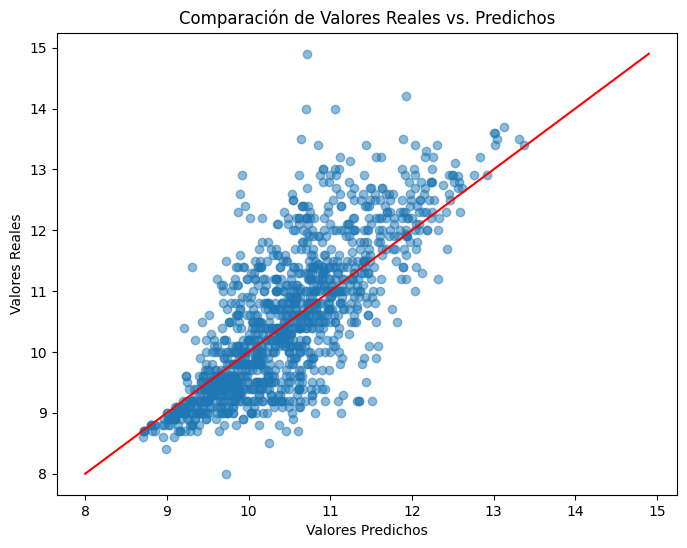

In [60]:
plot_predictions_vs_actual(y_test_reg, y_pred)

In [ ]:
import pickle # Save the model to a file

with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_grid.best_estimator_,file)

In [ ]:
# Load the model from the file
with open ('rf_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)